In [1]:
import cv2
import glob
import os
import pandas as pd
import numpy as np
import subprocess

# general imports
from copy import deepcopy
from pathlib import Path
from PIL import Image, ImageOps
from scipy.signal import resample

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, MSELoss, SmoothL1Loss
from torch.optim import Adam, SGD, lr_scheduler, LBFGS, RAdam, AdamW
from torch.utils.data import DataLoader
from torchmetrics import PeakSignalNoiseRatio
from adabelief_pytorch import AdaBelief
#from torchviz import make_dot

In [2]:
def generate_cdr1_to_cdr3_pdb(path, keepABC=True, lresidues=False):
    list_residues = ['START']
    with open(path, 'r') as f: # needs to be Chothia-numbered
        content = f.readlines()
        header_lines_important = range(4)
        header_lines = [content[i][0]=='R' for i in range(len(content))].count(True)
        h_range = range(26, 103)
        l_range = range(24, 98)
        chain_range = slice(21, 22)
        res_range = slice(23, 26)
        res_extra_letter = 26 #sometimes includes a letter 'A', 'B', 'C', ...
        h_chain_key = 'HCHAIN'
        l_chain_key = 'LCHAIN'
        idx_list = list(header_lines_important)
        new_path = path[:-4] + '_CDR1_to_CDR3' + path[-4:]
        
        # Getting the names of the heavy and light chains
        line = content[header_lines_important[-1]]
        if line.find(h_chain_key) != -1:
            h_pos = line.find(h_chain_key) + len(h_chain_key) + 1
            h_chain = line[h_pos:h_pos+1]
            
            # Obtaining the CDR1 to CDR3 lines for both chains
            for i, line in enumerate(content[header_lines:]):
                if line[chain_range].find(h_chain) != -1 and int(line[res_range]) in h_range:
                    if line[res_extra_letter] == ' ' or keepABC == True:
                        idx_list.append(i+header_lines)
                        if lresidues == True:
                            full_res = line[chain_range] + line[res_range] + line[res_extra_letter]
                            if full_res != list_residues[-1]:
                                list_residues.append(full_res)
        
        #line = content[header_lines_important[-1]]                       
        #if line.find(l_chain_key) != -1:
        #    l_pos = line.find(l_chain_key) + len(l_chain_key) + 1
        #    l_chain = line[l_pos:l_pos+1]
            
        #    # This separation ensures that heavy chain residues are enlisted first
        #    for i, line in enumerate(content[header_lines:]):
        #        if line[chain_range].find(l_chain) != -1 and int(line[res_range]) in l_range:
        #            if line[res_extra_letter] == ' ' or keepABC == True:
        #                idx_list.append(i+header_lines)
        #                if lresidues == True:
        #                    full_res = line[chain_range] + line[res_range] + line[res_extra_letter]
        #                    if full_res != list_residues[-1]:
        #                        list_residues.append(full_res)                   
    
    # List with name of every residue is saved if selected
    if lresidues == True:
        list_residues.append('END')
        np.save('/Users/kevinmicha/Documents/PhD/predicting-affinity/lists_of_residues/'+path[-8:-4]+'.npy', list_residues)
                        
                    
    # Creating new file
    with open(new_path, 'w') as f_new:
        f_new.writelines([content[l] for l in idx_list])

In [3]:
# Getting entries with affinity and antigen information
df = pd.read_csv('sabdab_summary_all.tsv', sep='\t', header=0)[['pdb', 'antigen_type', 'affinity']]
pathological = ['5omm', '1mj7', '1qfw', '1qyg', '3ifl', '3lrh', '3pp4', '3ru8', '3t0w', '3t0x', '4fqr', '4gxu', '4jfx', '4k3h', '4jfz', '4jg0', '4jg1', '4jn2', '4o4y', '4qxt', '4r3s', '4w6y', '4w6y', '5ies', '5ivn', '5j57', '5kvd', '5kzp', '5mes', '5nmv', '5sy8', '5t29', '5t5b', '5vag']
df.drop_duplicates(keep='first', inplace=True)
df = df[(df.antigen_type.notna()) & (df.antigen_type != 'NA')][['pdb', 'affinity']]
df = df[(df.affinity.notna()) & (df.affinity != 'None')]
df = df[~df['pdb'].isin(pathological)] # Removing pathological cases 
entries = list(df['pdb'])
affinity = list(df['affinity'])
modes = 30 # 'all' if no limit is desired, otherwise a number is required
numbering = ''
selection = '_CDR1_to_CDR3'
folder = str(Path.home() / 'Downloads') + '/all_structures/chothia/'
file_type_input = '.pdb'
dccm_map_path = 'dccm_maps/'

# Uncomment to generate

#for entry in entries:
#    file_name = entry + numbering + selection
#    path = folder + file_name + file_type_input
#    new_path = dccm_map_path + entry
#    generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input) 
#    subprocess.call(['/usr/local/bin/RScript pdb_to_dccm.r ' + str(path) + ' ' + str(new_path) + ' ' + str(modes)], shell=True, stdout=open(os.devnull, 'wb'))#    subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))
#
#
#    if os.path.exists(path):
#        os.remove(path)

In [4]:
dccm_paths = sorted(glob.glob(os.path.join(dccm_map_path, '*.npy')))
selected_entries = [dccm_paths[i][-8:-4] for i in range(len(dccm_paths))]
heavy = np.load('chain_lengths/heavy_lengths.npy').astype(int)
#light = np.load('chain_lengths/light_lengths.npy').astype(int)

assert list(np.load('chain_lengths/selected_entries.npy')) == selected_entries

for entry in selected_entries:
    assert len(np.load('/Users/kevinmicha/Documents/PhD/predicting-affinity/lists_of_residues/'+entry+'.npy'))-2 == heavy[selected_entries.index(entry)] #+ light[selected_entries.index(entry)]

# Uncomment to get the lengths (of the light and heavy chains) and lists of residues

#heavy = []
##light = []

#for entry in selected_entries:
#    file_name = entry + numbering + selection
#    path = folder + file_name + file_type_input
#    new_path = dccm_map_path + entry
#    generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input, keepABC=True, lresidues=True)
#    subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))
#   
#    if os.path.exists(path):
#        os.remove(path)
#    h, l = np.load('/Users/kevinmicha/Downloads/value.npy') # there might be a neat solution
#
#    heavy.append(h)
#    #light.append(l)
#np.save('heavy_lengths.npy', heavy)
##np.save('light_lengths.npy', light)
#np.save('selected_entries.npy', selected_entries)

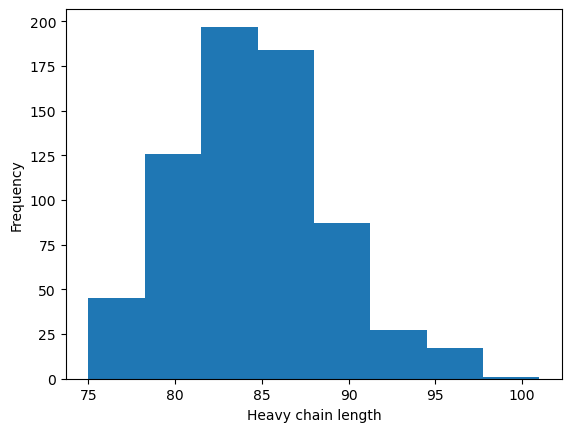

In [5]:
plt.hist(heavy, 8)
plt.xlabel('Heavy chain length')
plt.ylabel('Frequency')
plt.show()

In [6]:
#plt.hist(light, 8)
#plt.xlabel('Light chain length')
#plt.ylabel('Frequency')
#plt.show()

In [7]:
#plt.hist([sum(x) for x in zip(heavy, light)], 8)
#plt.xlabel('Total length')
#plt.ylabel('Frequency')
#plt.show()

In [8]:
# Code that obtains the longest/shortest possible chain

def noABC(residue):
    return residue[:-1]

residue_path = 'lists_of_residues/'
file_residues_paths = sorted(glob.glob(os.path.join('/Users/kevinmicha/Documents/PhD/predicting-affinity/'+residue_path, '*.npy')))
max_res_list = []

for f in file_residues_paths:
    current_list = np.load(f)[1:heavy[selected_entries.index(f[-8:-4])]+1]
    current_list = [x[1:] for x in current_list]
    max_res_list += list(set(current_list).difference(max_res_list))
    
max_res_list = sorted(max_res_list, key=noABC)
min_res_list = list(dict.fromkeys([x for x in max_res_list]))
max_res_list = [x.strip() for x in max_res_list]

for f in file_residues_paths:
    current_list = np.load(f)[1:heavy[selected_entries.index(f[-8:-4])]+1]
    current_list = [x[1:] for x in current_list]
    min_res_list = sorted(list(set(current_list).intersection(min_res_list)))

min_res_list = [x.strip() for x in min_res_list]

print('The longest chain has ' + str(len(max_res_list)) + ' residues, while the shortest has ' + str(len(min_res_list)))

The longest chain has 120 residues, while the shortest has 44


In [9]:
def generate_masked_image(img, idx, res_list=max_res_list, file_residues_paths=file_residues_paths, mode='fully-extended'):
    
    f = file_residues_paths[idx]
    
    current_list = np.load(f)[1:]#heavy[selected_entries.index(f[-8:-4])]+1]
    current_list = [x[1:].strip() for x in current_list]

    
    if mode == 'fully-cropped':
        idx_list = [i for i in range(len(current_list)) if current_list[i] in res_list]
        masked = img[idx_list,:][:,idx_list] 
        
    
    elif mode == 'fully-extended':
        max_res = len(res_list)
        masked = np.zeros((max_res, max_res))
        mask = np.zeros((max_res, max_res))
        idx_list = [i for i in range(max_res) if res_list[i] in current_list]
        for k, i in enumerate(idx_list):
            for l, j in enumerate(idx_list):
                masked[i, j] = img[k, l]
                mask[i, j] = 1

    else:
        raise NotImplementedError('Unknown mode: choose between fully-cropped and fully-extended')
        
    return masked, mask

In [10]:
# loading training images
imgs = []
kds = []
labels = []
data_path = '/Users/kevinmicha/Documents/PhD/predicting-affinity/' + dccm_map_path
file_paths = sorted(glob.glob(os.path.join(data_path, '*.npy')))
for f in file_paths:
    pdb_id = f[-8:-4]
    if pdb_id in selected_entries:
        idx = entries.index(pdb_id)
        idx_new = selected_entries.index(pdb_id)
        labels.append(pdb_id)
        imgs.append(generate_masked_image(np.load(f), idx_new, max_res_list, file_residues_paths, 'fully-extended')[0])
        kds.append(np.log10(np.float32(affinity[idx])))

assert labels == selected_entries

for pdb in selected_entries:
    assert np.float16(10**kds[selected_entries.index(pdb)] == np.float16(df[df['pdb']==pdb]['affinity'])).all()

# converting the list to numpy array
#train_x = np.array(np.triu(imgs))
train_x = np.array(imgs)
# defining the target
train_y = np.array(kds)

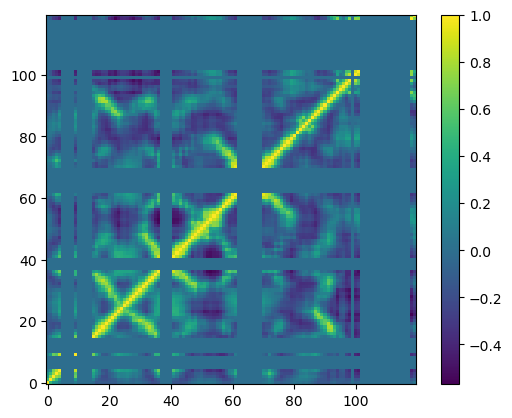

In [11]:
plt.imshow(train_x[16].reshape(train_x.shape[-1], train_x.shape[-1]), origin='lower')
plt.colorbar()

In [12]:
# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.046, random_state=42)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((652, 120, 120), (652,)), ((32, 120, 120), (32,)))

In [13]:
# converting training images into torch format
train_x = train_x.reshape(train_x.shape[0], 1, train_x.shape[1], train_x.shape[1])
train_x = train_x.astype(np.float32)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_y.astype(np.float32).reshape(train_y.shape[0], 1)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([652, 1, 120, 120]), torch.Size([652, 1]))

In [14]:
# converting validation images into torch format
val_x = val_x.reshape(val_x.shape[0], 1, train_x.shape[2], train_x.shape[2])
val_x = val_x.astype(np.float32)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(np.float32).reshape(val_y.shape[0], 1)
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape

(torch.Size([32, 1, 120, 120]), torch.Size([32, 1]))

In [63]:
n_filters = 3
filter_size = 7
pooling_size = 4
fully_connected_input = n_filters * ((train_x.shape[2] - filter_size + 1) // pooling_size) ** 2

class MultiLabelNN(Module):
    def __init__(self):
        super(MultiLabelNN, self).__init__()
        self.conv1 = Conv2d(1, n_filters, filter_size)
        self.conv1.weight.data = torch.tril(self.conv1.weight.data) + torch.transpose(torch.tril(self.conv1.weight.data), 2, 3)
        #self.conv1.weight.data.fill_(1e-5)
        self.pool = MaxPool2d(pooling_size, pooling_size)
        #self.conv2 = Conv2d(16, 32, 3)
        #self.conv2.weight.data = torch.tril(self.conv2.weight.data) + torch.transpose(torch.tril(self.conv2.weight.data), 2, 3)
        #self.conv2.weight.data = torch.transpose(self.conv2.weight.data, 2, 3)
        self.relu = ReLU()
        self.fc1 = Linear(fully_connected_input, 1, bias=False)
        #self.fc2 = Linear(128, 1)
        self.dropit = Dropout(p=0.05)
        #self.fc3 = Linear(128, 64)
        #self.fc4 = Linear(64, 1)

    def forward(self, x):
       #shape of x is (b_s, 32,32,1)
        x = self.conv1(x) + torch.transpose(self.conv1(x), 2, 3)#shape of x is (b_s, 28,28,132)
        #x = self.relu(x)
        x = self.pool(x) #shape of x now becomes (b_s X 14 x 14 x 32)
        #x = self.conv2(x) # shape(b_s, 10x10x64)
        inter = x = self.relu(x)#size is (b_s x 10 x 10 x 64)
        x = x.view(x.size(0), -1) # shape of x is now(b_s*2, 3200)
        #this is the problem 
        #you can fc1 to be of shape (6400,1024) and that will work 
        x = self.dropit(x)
        x = self.fc1(x)
        #x = self.relu(x)
        #x = self.fc2(x)
        #x = self.relu(x)
        #x = self.fc3(x)
        #x = self.relu(x)
        #x = self.fc4(x)


        return x.float(), inter


In [64]:
# defining the model
model = MultiLabelNN()
# defining the optimizer
#optimizer = Adam(model.parameters(), lr=3e-3)
#optimizer = AdamW(model.parameters(), lr=2e-3)
optimizer = AdaBelief(model.parameters(), lr=2.75e-3, eps=1e-8)
#optimizer = SGD(model.parameters(), lr=9e-4)
#scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, min_lr=3e-4, factor=0.1)
# defining the loss function
criterion = MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
Rectification enabled in AdaBelief
MultiLabelNN(
  (conv1): Conv2d(1, 3, kerne

In [65]:
def train(epoch):
    model.train()
    tr_loss = 0
    batch_size = 32
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)

    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()
    
    permutation = torch.randperm(x_train.size()[0])
    #val_indices = torch.randperm(x_val.size()[0])[:1]

    for i in range(0, x_train.size()[0], batch_size):

        
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = x_train[indices], y_train[indices]
        
        
        # prediction for training and validation set
        output_train, inter_filter = model(batch_x)

        # computing the training and validation loss
        loss_train = criterion(output_train, batch_y)

        # computing the updated weights of all the model parameters
        loss_train.backward()
        optimizer.step()
        
        # clearing the Gradients of the model parameters
        optimizer.zero_grad(set_to_none=True)
        
        tr_loss += loss_train.item() * batch_size / x_train.size()[0]
    output_val, inter_filter = model(x_val)#[val_indices])
    loss_val = criterion(output_val, y_val)#[val_indices])
    #scheduler.step(loss_val)
    train_losses.append(tr_loss)
    val_losses.append(loss_val)
    
    # printing the validation loss
    print('Epoch : ',epoch+1, '\t', 'train loss: ', tr_loss, 'val loss :', loss_val)
    print(output_val)
    print(y_val)#[val_indices])
        
    return tr_loss, loss_val, inter_filter


In [66]:
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []

In [135]:
# defining the number of epochs
n_max_epochs = 200

# training the model
for epoch in range(n_max_epochs):
    tr_loss, val_loss, inter_filter = train(epoch)
    if tr_loss < 0.05 and val_loss < 0.1:
        break

Epoch :  1 	 train loss:  1.5657648367384462 val loss : tensor(1.6505, grad_fn=<MseLossBackward0>)
tensor([[-7.4880],
        [-7.2043],
        [-8.0638],
        [-7.8290],
        [-8.1224],
        [-8.3827],
        [-6.6967],
        [-7.0334],
        [-9.2085],
        [-8.1827],
        [-9.7998],
        [-9.2325],
        [-6.7128],
        [-8.2605],
        [-9.5724],
        [-9.2946],
        [-6.0093],
        [-7.7824],
        [-7.7405],
        [-8.5998],
        [-8.9429],
        [-8.2432],
        [-8.5392],
        [-8.8844],
        [-7.2820],
        [-7.0057],
        [-6.7005],
        [-6.8836],
        [-6.6397],
        [-6.6088],
        [-8.5622],
        [-8.0995]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        [

Epoch :  7 	 train loss:  1.2946825261496329 val loss : tensor(1.3006, grad_fn=<MseLossBackward0>)
tensor([[-6.9116],
        [-8.1508],
        [-8.7335],
        [-8.1154],
        [-7.8921],
        [-8.6816],
        [-7.3782],
        [-7.5622],
        [-9.6258],
        [-8.9320],
        [-9.5704],
        [-9.8711],
        [-7.8595],
        [-8.4943],
        [-8.7583],
        [-9.8223],
        [-6.4485],
        [-8.9536],
        [-8.4673],
        [-9.3980],
        [-9.4064],
        [-8.8228],
        [-8.3337],
        [-8.7583],
        [-9.0749],
        [-7.2399],
        [-7.4993],
        [-7.5346],
        [-7.0615],
        [-7.1118],
        [-8.0188],
        [-8.7330]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        [

Epoch :  13 	 train loss:  1.4124577089321395 val loss : tensor(1.4857, grad_fn=<MseLossBackward0>)
tensor([[-7.4672],
        [-7.1528],
        [-7.8703],
        [-7.3320],
        [-7.3792],
        [-8.4191],
        [-7.3195],
        [-7.6689],
        [-8.8198],
        [-8.8066],
        [-8.7406],
        [-8.8011],
        [-6.9787],
        [-8.0390],
        [-9.5392],
        [-9.1309],
        [-6.7341],
        [-7.4938],
        [-8.2488],
        [-8.5852],
        [-8.4116],
        [-7.8570],
        [-8.4329],
        [-8.1082],
        [-7.9375],
        [-7.8060],
        [-6.9453],
        [-6.7704],
        [-6.8799],
        [-6.7714],
        [-8.0216],
        [-8.5668]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        

Epoch :  19 	 train loss:  1.252712760234903 val loss : tensor(1.4889, grad_fn=<MseLossBackward0>)
tensor([[-7.0694],
        [-7.9068],
        [-8.0066],
        [-7.0974],
        [-7.5060],
        [-8.4106],
        [-5.7957],
        [-7.3810],
        [-8.7863],
        [-8.1820],
        [-8.8526],
        [-9.1619],
        [-6.9279],
        [-7.9343],
        [-8.8487],
        [-8.7888],
        [-5.8914],
        [-8.3827],
        [-8.5961],
        [-9.2575],
        [-8.1097],
        [-7.9508],
        [-8.2071],
        [-8.5241],
        [-8.0690],
        [-6.5105],
        [-6.2208],
        [-7.5699],
        [-6.4148],
        [-6.9516],
        [-8.4933],
        [-8.5169]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        [

Epoch :  25 	 train loss:  1.2599857716472602 val loss : tensor(1.2740, grad_fn=<MseLossBackward0>)
tensor([[-7.4799],
        [-7.5572],
        [-8.5438],
        [-8.0934],
        [-8.0057],
        [-8.6488],
        [-6.6277],
        [-7.0620],
        [-9.6290],
        [-8.2553],
        [-8.5150],
        [-9.0963],
        [-7.3563],
        [-8.6980],
        [-9.4234],
        [-9.4786],
        [-6.9976],
        [-9.0481],
        [-8.4012],
        [-9.4992],
        [-8.8180],
        [-7.6692],
        [-8.9758],
        [-8.8392],
        [-8.1946],
        [-6.1677],
        [-7.0848],
        [-7.3429],
        [-6.8433],
        [-6.9642],
        [-8.9165],
        [-9.0576]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        

Epoch :  31 	 train loss:  1.2596382363442262 val loss : tensor(1.2621, grad_fn=<MseLossBackward0>)
tensor([[-7.2836],
        [-7.2285],
        [-8.7090],
        [-7.3136],
        [-7.4771],
        [-8.5716],
        [-5.1415],
        [-6.9788],
        [-9.2767],
        [-8.1296],
        [-8.8752],
        [-8.9147],
        [-7.1746],
        [-7.5048],
        [-7.1745],
        [-8.7096],
        [-5.7177],
        [-8.4659],
        [-7.2147],
        [-9.1246],
        [-8.5254],
        [-8.3692],
        [-8.6744],
        [-8.6403],
        [-7.1868],
        [-7.2592],
        [-7.0349],
        [-7.7705],
        [-6.6406],
        [-6.8852],
        [-7.8426],
        [-8.8809]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        

Epoch :  37 	 train loss:  1.5880624648252146 val loss : tensor(1.1378, grad_fn=<MseLossBackward0>)
tensor([[-9.4107],
        [-7.9676],
        [-8.8233],
        [-7.9202],
        [-8.3486],
        [-9.2403],
        [-6.8317],
        [-7.4418],
        [-9.3764],
        [-9.2866],
        [-9.8359],
        [-9.3687],
        [-6.9447],
        [-8.5337],
        [-8.5653],
        [-9.7451],
        [-6.4295],
        [-8.1341],
        [-8.6462],
        [-9.5012],
        [-9.3245],
        [-9.1054],
        [-9.0126],
        [-9.2663],
        [-8.8614],
        [-7.9557],
        [-7.6362],
        [-8.2036],
        [-7.4533],
        [-7.5845],
        [-7.8799],
        [-9.9409]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        

Epoch :  43 	 train loss:  1.2727056017682594 val loss : tensor(1.4277, grad_fn=<MseLossBackward0>)
tensor([[-6.8108],
        [-7.2520],
        [-8.8490],
        [-7.7361],
        [-7.6569],
        [-7.5648],
        [-6.7802],
        [-7.1522],
        [-9.2704],
        [-8.8963],
        [-9.3342],
        [-8.6638],
        [-7.5510],
        [-8.3733],
        [-9.0569],
        [-9.4945],
        [-6.7899],
        [-8.3973],
        [-8.7237],
        [-9.2525],
        [-9.4011],
        [-8.1553],
        [-8.7458],
        [-8.3562],
        [-9.3772],
        [-8.1846],
        [-6.7287],
        [-6.5229],
        [-7.3491],
        [-7.0973],
        [-8.7610],
        [-8.9782]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        

Epoch :  49 	 train loss:  1.2789586804395805 val loss : tensor(1.7321, grad_fn=<MseLossBackward0>)
tensor([[ -7.4066],
        [ -7.6087],
        [ -8.8527],
        [ -8.1642],
        [ -8.7764],
        [ -7.8707],
        [ -7.8392],
        [ -7.5660],
        [ -9.3097],
        [ -9.6744],
        [ -9.3145],
        [ -8.8534],
        [ -7.4733],
        [ -8.2341],
        [ -9.8045],
        [ -9.3472],
        [ -6.7708],
        [ -8.2073],
        [ -9.1350],
        [ -8.9988],
        [-10.1120],
        [ -8.2873],
        [ -8.4271],
        [ -8.6982],
        [ -8.0310],
        [ -7.8658],
        [ -7.0701],
        [ -7.3720],
        [ -6.9223],
        [ -6.5016],
        [ -8.0517],
        [ -8.5203]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.739

Epoch :  55 	 train loss:  1.239517908154821 val loss : tensor(1.5719, grad_fn=<MseLossBackward0>)
tensor([[ -7.2904],
        [ -8.0760],
        [ -8.2827],
        [ -7.6502],
        [ -8.0638],
        [ -8.5229],
        [ -5.9394],
        [ -7.1738],
        [ -9.5191],
        [ -9.0772],
        [ -9.4691],
        [ -8.9378],
        [ -8.0050],
        [ -7.6650],
        [-10.3558],
        [ -9.6618],
        [ -7.4311],
        [ -8.8792],
        [ -8.0834],
        [ -8.6196],
        [ -9.7354],
        [ -8.3832],
        [ -8.9185],
        [ -8.8131],
        [ -7.5728],
        [ -8.2557],
        [ -7.8844],
        [ -7.1473],
        [ -6.7198],
        [ -7.2319],
        [ -7.6086],
        [-10.3150]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399

Epoch :  61 	 train loss:  1.3735111476453534 val loss : tensor(2.0088, grad_fn=<MseLossBackward0>)
tensor([[ -6.5975],
        [ -8.1132],
        [ -8.3907],
        [ -8.2459],
        [ -8.0769],
        [ -7.8769],
        [ -6.6056],
        [ -7.2793],
        [ -8.4722],
        [ -9.1904],
        [ -9.2322],
        [ -8.9656],
        [ -7.1760],
        [ -7.3183],
        [ -9.4409],
        [ -8.4106],
        [ -8.5909],
        [ -8.4380],
        [ -7.6762],
        [-10.1520],
        [ -9.1052],
        [ -8.3569],
        [ -8.4400],
        [ -8.6536],
        [ -9.0309],
        [ -6.7328],
        [ -7.0892],
        [ -7.0923],
        [ -7.3747],
        [ -6.8612],
        [ -8.9374],
        [ -8.0445]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.739

Epoch :  67 	 train loss:  1.1994265076572905 val loss : tensor(1.3691, grad_fn=<MseLossBackward0>)
tensor([[-7.5615],
        [-8.0121],
        [-7.5874],
        [-8.0038],
        [-7.9049],
        [-8.5057],
        [-6.9378],
        [-7.5478],
        [-9.3040],
        [-9.3582],
        [-9.2826],
        [-9.1651],
        [-7.4383],
        [-7.3893],
        [-9.9516],
        [-8.5144],
        [-6.5963],
        [-8.2868],
        [-7.7563],
        [-8.7626],
        [-9.2108],
        [-7.9181],
        [-8.0177],
        [-8.3867],
        [-8.0903],
        [-8.1466],
        [-6.8874],
        [-7.7497],
        [-6.9901],
        [-7.2757],
        [-9.2642],
        [-9.1582]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        

Epoch :  73 	 train loss:  1.34721366320651 val loss : tensor(1.6775, grad_fn=<MseLossBackward0>)
tensor([[-7.0257],
        [-7.7136],
        [-8.2786],
        [-7.9471],
        [-7.6783],
        [-8.8705],
        [-5.0443],
        [-7.6420],
        [-9.0411],
        [-8.6386],
        [-8.9305],
        [-8.7061],
        [-6.9541],
        [-7.7115],
        [-9.5003],
        [-9.1393],
        [-8.2275],
        [-8.5591],
        [-8.1172],
        [-9.4181],
        [-9.2892],
        [-8.6153],
        [-7.7451],
        [-8.5393],
        [-7.7984],
        [-6.8940],
        [-7.0067],
        [-6.6831],
        [-6.8442],
        [-6.4882],
        [-8.2795],
        [-8.1475]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        [ 

Epoch :  79 	 train loss:  1.330496401874566 val loss : tensor(1.4926, grad_fn=<MseLossBackward0>)
tensor([[ -6.9881],
        [ -7.9676],
        [ -7.9665],
        [ -8.1039],
        [ -8.2659],
        [ -8.6285],
        [ -5.5228],
        [ -6.8776],
        [ -9.0714],
        [ -9.2161],
        [ -9.3501],
        [ -9.3876],
        [ -7.7267],
        [ -8.1410],
        [ -9.8487],
        [ -8.5405],
        [ -6.2772],
        [ -8.3509],
        [ -8.2176],
        [-10.2338],
        [ -9.5579],
        [ -8.6478],
        [ -8.6072],
        [ -8.3921],
        [ -8.3028],
        [ -8.3659],
        [ -6.8729],
        [ -7.6190],
        [ -6.9409],
        [ -6.7330],
        [ -8.5749],
        [ -8.3424]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399

Epoch :  85 	 train loss:  1.3103807484445396 val loss : tensor(1.4429, grad_fn=<MseLossBackward0>)
tensor([[-6.9831],
        [-8.1723],
        [-8.5340],
        [-8.3448],
        [-8.2496],
        [-7.8603],
        [-5.6125],
        [-7.4053],
        [-9.0745],
        [-8.8153],
        [-9.3458],
        [-9.0117],
        [-7.7882],
        [-8.3281],
        [-9.4964],
        [-8.9945],
        [-7.0610],
        [-8.9945],
        [-7.9848],
        [-9.3409],
        [-9.6921],
        [-8.4882],
        [-8.5285],
        [-9.0810],
        [-8.1838],
        [-8.2462],
        [-7.0394],
        [-7.7551],
        [-6.4840],
        [-7.3654],
        [-9.0060],
        [-8.8464]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        

Epoch :  91 	 train loss:  1.3143247036846137 val loss : tensor(1.1914, grad_fn=<MseLossBackward0>)
tensor([[-6.9114],
        [-7.2338],
        [-8.6625],
        [-8.3229],
        [-8.1077],
        [-8.2894],
        [-5.9121],
        [-7.2810],
        [-9.1054],
        [-9.3921],
        [-8.8694],
        [-8.5423],
        [-6.7688],
        [-8.0590],
        [-8.4852],
        [-9.1830],
        [-5.7328],
        [-8.5138],
        [-7.9943],
        [-9.3760],
        [-9.4662],
        [-9.0646],
        [-8.8388],
        [-9.0822],
        [-8.0253],
        [-8.2570],
        [-7.7435],
        [-8.1926],
        [-6.8044],
        [-6.7474],
        [-8.2882],
        [-8.3568]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        

Epoch :  97 	 train loss:  1.212891213001649 val loss : tensor(0.8304, grad_fn=<MseLossBackward0>)
tensor([[ -8.4074],
        [ -7.0688],
        [ -8.1585],
        [ -7.8189],
        [ -8.4062],
        [ -9.2244],
        [ -6.4018],
        [ -6.9259],
        [ -9.6842],
        [ -9.8254],
        [ -8.9506],
        [ -9.3623],
        [ -7.0446],
        [ -8.0367],
        [ -9.5274],
        [ -9.1851],
        [ -5.2489],
        [ -8.6524],
        [ -7.3396],
        [ -9.2647],
        [ -8.5309],
        [ -8.0870],
        [ -8.8181],
        [ -8.7512],
        [ -7.8931],
        [ -7.5296],
        [ -7.9116],
        [ -8.1703],
        [ -6.5104],
        [ -7.1830],
        [ -8.7993],
        [-10.0236]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399

Epoch :  103 	 train loss:  1.4270114606143505 val loss : tensor(1.9761, grad_fn=<MseLossBackward0>)
tensor([[ -8.2802],
        [ -8.5766],
        [ -8.8357],
        [ -8.1824],
        [ -8.5658],
        [ -9.1251],
        [ -6.9247],
        [ -7.8127],
        [ -9.1001],
        [ -9.6328],
        [ -9.9400],
        [ -9.1565],
        [ -7.1277],
        [ -7.9473],
        [-11.2214],
        [ -9.6291],
        [ -8.2051],
        [ -8.7380],
        [ -8.2204],
        [ -8.6021],
        [ -9.9587],
        [ -8.4652],
        [ -9.1988],
        [ -8.8204],
        [ -8.9582],
        [ -8.4763],
        [ -7.5745],
        [ -7.0360],
        [ -6.6151],
        [ -7.2482],
        [ -8.2942],
        [ -8.3644]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.73

Epoch :  109 	 train loss:  1.289882460986178 val loss : tensor(1.3352, grad_fn=<MseLossBackward0>)
tensor([[-6.8379],
        [-8.0741],
        [-7.6621],
        [-7.7908],
        [-7.8064],
        [-8.0964],
        [-5.7793],
        [-7.3231],
        [-9.0213],
        [-9.1227],
        [-8.9070],
        [-8.8338],
        [-7.9488],
        [-7.3825],
        [-8.7484],
        [-8.8446],
        [-6.6935],
        [-8.5875],
        [-7.2605],
        [-9.3812],
        [-9.2484],
        [-8.3257],
        [-8.6543],
        [-8.1130],
        [-8.0046],
        [-7.8308],
        [-7.4438],
        [-8.4615],
        [-6.9481],
        [-6.8453],
        [-8.5853],
        [-8.4550]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        

Epoch :  115 	 train loss:  1.249773452618371 val loss : tensor(1.5818, grad_fn=<MseLossBackward0>)
tensor([[-6.2502],
        [-7.4068],
        [-8.4312],
        [-7.6722],
        [-7.9267],
        [-8.1906],
        [-5.1780],
        [-7.5072],
        [-9.2766],
        [-8.3113],
        [-9.0798],
        [-9.2556],
        [-7.2054],
        [-8.2635],
        [-9.5806],
        [-9.5939],
        [-6.0469],
        [-9.1815],
        [-7.6410],
        [-9.2205],
        [-9.3120],
        [-8.1322],
        [-8.4690],
        [-9.0787],
        [-8.6255],
        [-7.3672],
        [-6.1159],
        [-7.0594],
        [-6.5346],
        [-7.3169],
        [-8.3467],
        [-7.7950]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        

Epoch :  121 	 train loss:  1.2463558173618434 val loss : tensor(1.5679, grad_fn=<MseLossBackward0>)
tensor([[ -7.8533],
        [ -8.0490],
        [ -9.1401],
        [ -8.5538],
        [ -8.8185],
        [ -8.5394],
        [ -6.3834],
        [ -7.6018],
        [-10.0396],
        [ -8.1267],
        [ -9.2415],
        [ -9.1275],
        [ -7.4970],
        [ -8.1695],
        [-10.2209],
        [ -9.3004],
        [ -7.1257],
        [ -8.9690],
        [ -8.1237],
        [ -9.7401],
        [ -9.3852],
        [ -8.5191],
        [ -9.0233],
        [ -9.0353],
        [ -9.1386],
        [ -7.4658],
        [ -7.1858],
        [ -7.9618],
        [ -7.6736],
        [ -7.0506],
        [ -8.6542],
        [ -8.3863]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.73

Epoch :  127 	 train loss:  1.256216622569078 val loss : tensor(1.6894, grad_fn=<MseLossBackward0>)
tensor([[-6.0760],
        [-7.1199],
        [-7.6738],
        [-7.3217],
        [-8.1964],
        [-8.3493],
        [-5.0678],
        [-7.7278],
        [-9.1429],
        [-9.0603],
        [-9.5589],
        [-9.1389],
        [-7.4881],
        [-7.6866],
        [-9.7085],
        [-8.8724],
        [-7.0772],
        [-8.3026],
        [-7.6469],
        [-8.5886],
        [-9.9260],
        [-8.2874],
        [-9.1184],
        [-8.5850],
        [-8.4903],
        [-8.1337],
        [-6.5983],
        [-7.1764],
        [-5.9029],
        [-7.1332],
        [-8.8299],
        [-8.9631]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        

Epoch :  133 	 train loss:  1.3465551949717516 val loss : tensor(2.0243, grad_fn=<MseLossBackward0>)
tensor([[-6.4350],
        [-7.2935],
        [-7.7844],
        [-7.7146],
        [-8.0090],
        [-7.3720],
        [-5.4569],
        [-6.9466],
        [-9.4347],
        [-9.4743],
        [-9.0505],
        [-8.8139],
        [-7.2644],
        [-7.6502],
        [-9.5509],
        [-8.5087],
        [-7.8957],
        [-8.9426],
        [-7.6114],
        [-7.8631],
        [-9.5786],
        [-7.9205],
        [-8.7105],
        [-8.8056],
        [-6.9994],
        [-8.1564],
        [-6.4423],
        [-6.5755],
        [-6.3476],
        [-6.9139],
        [-9.1023],
        [-8.4722]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
       

Epoch :  139 	 train loss:  1.2980856953954405 val loss : tensor(1.5275, grad_fn=<MseLossBackward0>)
tensor([[ -7.7584],
        [ -7.5626],
        [ -8.2173],
        [ -7.3872],
        [ -8.3148],
        [ -8.5004],
        [ -5.0260],
        [ -7.1314],
        [ -9.9280],
        [-10.5047],
        [ -8.8554],
        [ -8.6550],
        [ -7.3328],
        [ -8.6081],
        [-11.2656],
        [ -8.8499],
        [ -8.1124],
        [ -8.6894],
        [ -8.1290],
        [ -9.5308],
        [ -9.7885],
        [ -8.5569],
        [ -8.3660],
        [ -8.9068],
        [ -8.9193],
        [ -7.9505],
        [ -7.5004],
        [ -8.1342],
        [ -6.9134],
        [ -6.7574],
        [ -9.3526],
        [ -9.2880]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.73

Epoch :  145 	 train loss:  1.3735576758355452 val loss : tensor(1.7338, grad_fn=<MseLossBackward0>)
tensor([[ -6.9714],
        [ -7.6208],
        [ -8.2056],
        [ -7.7131],
        [ -8.1451],
        [ -7.6783],
        [ -6.4897],
        [ -7.1647],
        [ -9.6781],
        [ -9.8285],
        [ -9.2536],
        [ -8.7817],
        [ -7.0218],
        [ -8.6769],
        [-10.8158],
        [ -9.8241],
        [ -7.8734],
        [ -9.0700],
        [ -8.0382],
        [ -9.6773],
        [-10.0067],
        [ -8.4506],
        [ -9.0382],
        [ -8.6728],
        [ -7.8105],
        [ -6.8957],
        [ -7.4273],
        [ -7.3874],
        [ -8.1070],
        [ -6.0810],
        [ -8.3027],
        [ -9.2907]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.73

Epoch :  151 	 train loss:  1.4297470461371486 val loss : tensor(1.7584, grad_fn=<MseLossBackward0>)
tensor([[-6.4123],
        [-7.6305],
        [-8.2709],
        [-7.4366],
        [-7.7977],
        [-7.4823],
        [-5.0033],
        [-7.4420],
        [-9.7927],
        [-9.2159],
        [-8.6779],
        [-9.0900],
        [-7.2708],
        [-7.7313],
        [-9.5252],
        [-9.1973],
        [-6.7289],
        [-7.7206],
        [-6.8695],
        [-8.9827],
        [-8.1606],
        [-8.3801],
        [-7.4585],
        [-8.4758],
        [-7.1043],
        [-7.7371],
        [-6.4612],
        [-8.3043],
        [-5.6457],
        [-7.2574],
        [-8.1705],
        [-7.2490]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
       

Epoch :  157 	 train loss:  1.4508775611596605 val loss : tensor(2.2587, grad_fn=<MseLossBackward0>)
tensor([[ -6.5964],
        [ -7.4413],
        [ -7.5471],
        [ -7.5381],
        [ -7.8611],
        [ -7.6350],
        [ -5.4519],
        [ -6.7647],
        [ -8.6841],
        [ -8.1506],
        [ -8.8447],
        [ -8.6739],
        [ -6.0438],
        [ -7.8410],
        [-10.7603],
        [ -8.8695],
        [ -7.1905],
        [ -9.1086],
        [ -7.5469],
        [ -9.0247],
        [ -9.6591],
        [ -7.6265],
        [ -8.4874],
        [ -8.9032],
        [ -7.9729],
        [ -7.7193],
        [ -6.0592],
        [ -6.4667],
        [ -7.5650],
        [ -6.1764],
        [ -8.0839],
        [ -8.6197]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.73

Epoch :  163 	 train loss:  1.3650003532690504 val loss : tensor(1.8910, grad_fn=<MseLossBackward0>)
tensor([[ -6.7800],
        [ -8.3457],
        [ -8.1204],
        [ -7.9617],
        [ -7.9549],
        [ -7.5874],
        [ -5.1767],
        [ -7.3631],
        [ -9.6299],
        [ -8.7830],
        [ -9.5586],
        [ -8.8848],
        [ -7.5410],
        [ -7.7998],
        [-11.3353],
        [ -9.3110],
        [ -7.8852],
        [ -8.7446],
        [ -7.9022],
        [ -9.2111],
        [ -8.9103],
        [ -8.6432],
        [ -8.9336],
        [ -9.2851],
        [ -8.7715],
        [ -7.6866],
        [ -7.2610],
        [ -7.7719],
        [ -6.9685],
        [ -7.3573],
        [ -8.0351],
        [ -9.4883]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.73

Epoch :  169 	 train loss:  1.229243790445152 val loss : tensor(1.8490, grad_fn=<MseLossBackward0>)
tensor([[-6.6774],
        [-7.3219],
        [-8.3565],
        [-8.0773],
        [-7.2490],
        [-7.6292],
        [-4.7083],
        [-7.3246],
        [-9.0673],
        [-8.4005],
        [-8.2897],
        [-8.5575],
        [-6.4121],
        [-7.2709],
        [-9.6013],
        [-8.6076],
        [-7.8408],
        [-8.3253],
        [-7.3982],
        [-9.8837],
        [-9.1325],
        [-8.1756],
        [-8.2701],
        [-7.6794],
        [-7.4709],
        [-7.9250],
        [-7.1971],
        [-7.2181],
        [-7.0145],
        [-6.6802],
        [-8.0699],
        [-7.8382]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        

Epoch :  175 	 train loss:  1.4010942581972463 val loss : tensor(1.7451, grad_fn=<MseLossBackward0>)
tensor([[-6.7433],
        [-7.7462],
        [-8.1969],
        [-7.3594],
        [-7.5541],
        [-8.2702],
        [-4.8888],
        [-7.0583],
        [-9.5035],
        [-8.6799],
        [-8.9796],
        [-8.7182],
        [-7.0701],
        [-7.7852],
        [-9.5691],
        [-8.4936],
        [-6.7072],
        [-8.6498],
        [-7.0387],
        [-8.0517],
        [-9.8167],
        [-8.0898],
        [-7.5467],
        [-8.4221],
        [-7.6052],
        [-7.6262],
        [-6.3619],
        [-6.8283],
        [-6.6139],
        [-6.4257],
        [-8.7338],
        [-7.8529]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
       

Epoch :  181 	 train loss:  1.2354523418871173 val loss : tensor(1.8976, grad_fn=<MseLossBackward0>)
tensor([[ -6.3603],
        [ -7.0703],
        [ -8.0873],
        [ -7.7016],
        [ -7.8546],
        [ -7.5942],
        [ -5.4150],
        [ -7.2173],
        [ -9.0388],
        [ -8.7607],
        [ -8.9869],
        [ -8.6102],
        [ -7.2791],
        [ -7.5127],
        [ -9.4979],
        [ -8.9640],
        [ -6.8022],
        [ -8.4940],
        [ -7.8378],
        [ -8.9243],
        [-10.1660],
        [ -7.8781],
        [ -8.1784],
        [ -8.5969],
        [ -8.1481],
        [ -8.1483],
        [ -6.6161],
        [ -7.1834],
        [ -6.8312],
        [ -6.3834],
        [ -8.0931],
        [ -7.6005]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.73

Epoch :  187 	 train loss:  1.211839629097219 val loss : tensor(1.3065, grad_fn=<MseLossBackward0>)
tensor([[-7.3573],
        [-7.4468],
        [-8.6052],
        [-7.5738],
        [-8.2902],
        [-8.0226],
        [-5.6112],
        [-7.7779],
        [-9.8130],
        [-9.6566],
        [-9.6706],
        [-8.2381],
        [-7.4787],
        [-7.4826],
        [-9.0620],
        [-8.6877],
        [-6.8335],
        [-8.7394],
        [-7.8800],
        [-9.2790],
        [-8.7820],
        [-8.6169],
        [-7.6654],
        [-8.1747],
        [-8.2579],
        [-7.1670],
        [-6.9223],
        [-7.0566],
        [-6.0288],
        [-7.6217],
        [-8.3039],
        [-7.7552]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.7399],
        [ -7.1938],
        

Epoch :  193 	 train loss:  1.2405717563044074 val loss : tensor(1.0139, grad_fn=<MseLossBackward0>)
tensor([[ -7.8221],
        [ -7.8094],
        [ -7.9712],
        [ -7.1936],
        [ -7.5792],
        [ -7.6946],
        [ -5.8676],
        [ -7.8093],
        [ -9.8071],
        [-10.0693],
        [ -8.3636],
        [ -8.7612],
        [ -6.9258],
        [ -8.0262],
        [ -8.9320],
        [ -8.6151],
        [ -6.6896],
        [ -8.9319],
        [ -7.6099],
        [ -8.6122],
        [ -8.6614],
        [ -8.6945],
        [ -7.8009],
        [ -8.4095],
        [ -7.9395],
        [ -7.9249],
        [ -7.2946],
        [ -7.1576],
        [ -5.8029],
        [ -7.3733],
        [ -8.4398],
        [ -8.9552]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.73

Epoch :  199 	 train loss:  1.2534543721953784 val loss : tensor(1.8926, grad_fn=<MseLossBackward0>)
tensor([[ -7.9509],
        [ -7.4508],
        [ -8.7167],
        [ -7.3392],
        [ -7.5107],
        [ -7.8894],
        [ -5.9129],
        [ -7.3732],
        [ -9.5985],
        [ -8.3835],
        [ -9.0820],
        [ -9.2378],
        [ -7.9389],
        [ -7.4538],
        [-11.4347],
        [ -8.9258],
        [ -7.4053],
        [ -8.2912],
        [ -7.9344],
        [ -9.7779],
        [ -9.0522],
        [ -8.4982],
        [ -8.6509],
        [ -8.6192],
        [ -8.2649],
        [ -7.0691],
        [ -6.7318],
        [ -7.2489],
        [ -5.8191],
        [ -6.6996],
        [ -8.4314],
        [ -8.1522]], grad_fn=<MmBackward0>)
tensor([[ -8.7447],
        [ -7.3372],
        [ -8.6576],
        [ -8.3010],
        [ -6.6198],
        [ -9.8861],
        [ -5.7959],
        [ -8.6271],
        [-11.1675],
        [-10.7959],
        [ -8.3872],
        [ -7.73

-3.0386477

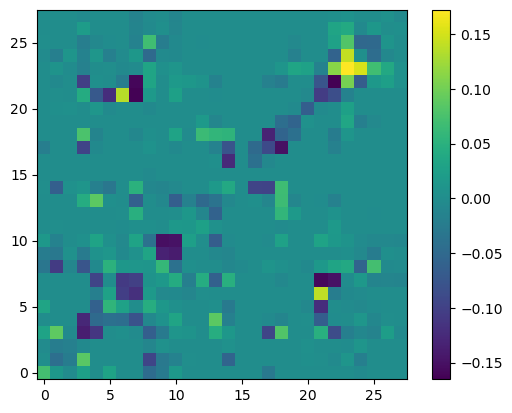

In [136]:
img_1 = np.multiply(np.mean(inter_filter.detach().numpy(), axis=0)[0], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[0].reshape(size_le, size_le))
plt.imshow(img_1, origin='lower')
plt.colorbar()
img_1.sum()

0.0

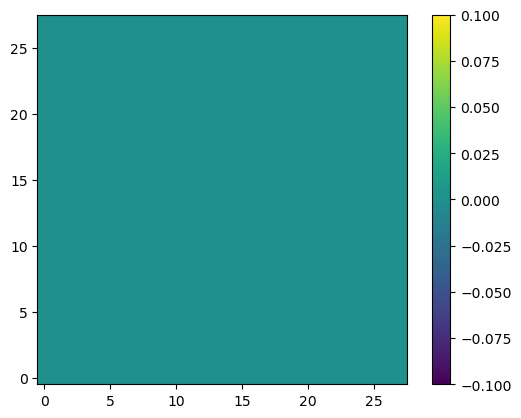

In [137]:
img_2 = np.multiply(np.mean(inter_filter.detach().numpy(), axis=0)[1], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[1].reshape(size_le, size_le))
plt.imshow(img_2, origin='lower')
plt.colorbar()
img_2.sum()

-4.839233

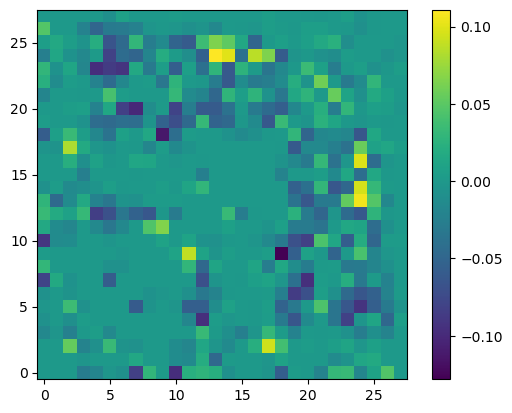

In [138]:
img_3 = np.multiply(np.mean(inter_filter.detach().numpy(), axis=0)[2], model.fc1.weight.data.numpy().reshape(n_filters,size_le**2)[2].reshape(size_le, size_le))
plt.imshow(img_3, origin='lower')
plt.colorbar()
img_3.sum()

-7.8778806

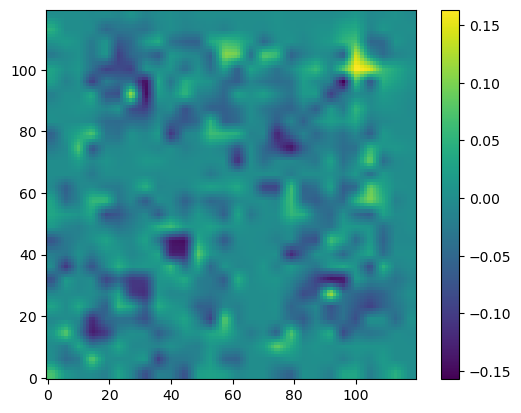

In [139]:
img = img_1 + img_2 + img_3
plt.imshow(cv2.resize(img, dsize=(120,120)), origin='lower')
plt.colorbar()
img.sum()

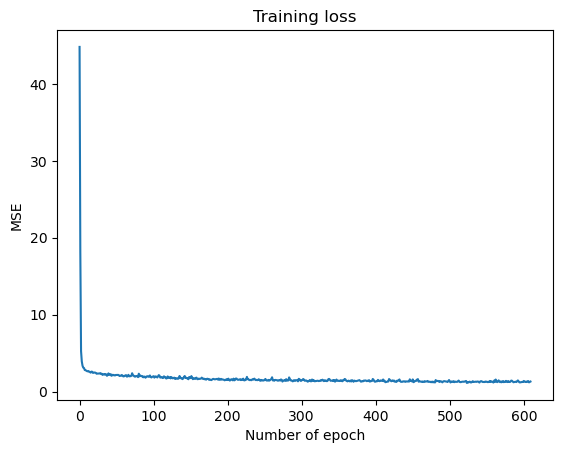

In [140]:
plt.plot([train_losses[i] for i in range(len(train_losses))])
plt.title('Training loss')
plt.xlabel('Number of epoch')
plt.ylabel('MSE')
plt.show()

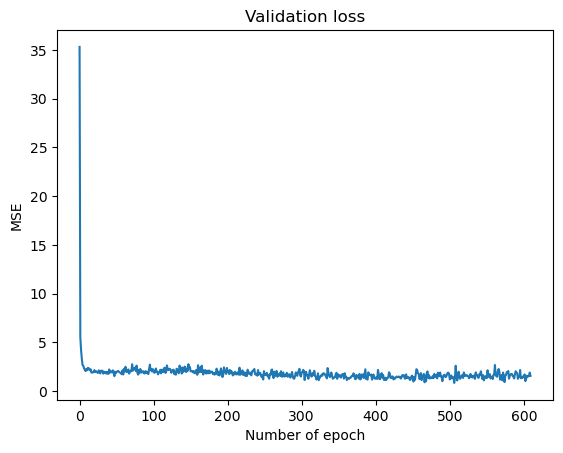

In [141]:
plt.plot([val_losses[i].detach().numpy() for i in range(len(val_losses[10:]))])
plt.title('Validation loss')
plt.xlabel('Number of epoch')
plt.ylabel('MSE')
plt.show()

In [133]:
model.eval()
model(Variable(train_x[40:55]))[0]

tensor([[-7.4470],
        [-5.8270],
        [-9.1386],
        [-8.4808],
        [-8.3960],
        [-5.9920],
        [-8.4304],
        [-7.4883],
        [-8.7562],
        [-6.1675],
        [-5.7728],
        [-4.4016],
        [-8.5085],
        [-7.0504],
        [-7.9905]], grad_fn=<MmBackward0>)

In [134]:
Variable(train_y[40:55])

tensor([[ -5.5638],
        [ -5.0555],
        [-10.2366],
        [ -8.7959],
        [ -6.5575],
        [ -7.0000],
        [-10.3979],
        [ -6.2218],
        [ -9.3665],
        [ -6.6289],
        [ -5.3979],
        [ -4.5086],
        [ -7.4001],
        [ -7.9245],
        [ -6.5229]])

In [24]:
file_paths

['/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1a4k.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1aj7.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1axs.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1bj1.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1bvk.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1c12.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1c5c.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1ct8.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1cz8.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1d6v.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dbb.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dee.npy',
 '/Users/kevinmicha/Documents/PhD/predicting-affinity/dccm_maps/1dl7.npy',
 '/Users/kevinmicha/Docum

In [25]:
entry = '1t66'
download_path = '/Users/kevinmicha/Downloads/'
file_name = entry + numbering + selection
path = folder + file_name + file_type_input
new_path = download_path + entry + '_map'
generate_cdr1_to_cdr3_pdb(folder+entry+numbering+file_type_input, lresidues=False)  
subprocess.call(['/usr/local/bin/RScript pdb_to_dccm.r ' + str(path) + ' ' + str(new_path) + ' ' + str(modes)], shell=True, stdout=open(os.devnull, 'wb'))#    subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))
subprocess.call(['/usr/local/bin/RScript get_chain_lengths.r ' + str(path)], shell=True, stdout=open(os.devnull, 'wb'))

if os.path.exists(path):
    os.remove(path)
h, l = np.load(download_path + 'value.npy') 

In [26]:
f = download_path + entry + '_map' + '.npy'
res_path = np.array([download_path + entry + '_residues' + '.npy'])
test_array, mask = generate_masked_image(np.load(f), idx=0, res_list=max_res_list, file_residues_paths=res_path, mode='fully-extended')
test_sample = torch.from_numpy(test_array.reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32))

In [27]:
model.eval()
model(test_sample)

(tensor([[-7.3032]], grad_fn=<MmBackward0>),
 tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.7649, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.5456, 0.3731, 0.7107],
           [0.0000, 0.0000, 0.0000,  ..., 0.2862, 0.9807, 1.1462],
           ...,
           [0.7649, 0.5456, 0.2862,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.3731, 0.9807,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.7107, 1.1462,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.5127, 0.7765, 0.0000,  ..., 0.0000, 0.1516, 0.3084],
           [0.7765, 0.6318, 0.7815,  ..., 0.0141, 0.3356, 0.6004],
           [0.0000, 0.7815, 0.0000,  ..., 0.0073, 0.5162, 0.7716],
           ...,
           [0.0000, 0.0141, 0.0073,  ..., 0.0505, 0.2655, 0.0000],
           [0.1516, 0.3356, 0.5162,  ..., 0.2655, 0.0708, 0.0000],
           [0.3084, 0.6004, 0.7716,  ..., 0.0000, 0.0000, 0.0704]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.9021, 1.4069, 1.2436],
           [0.0000, 0.0000, 0.0000,  ..., 0.70

In [28]:
prediction = 10**model(test_sample).detach().numpy()
prediction

AttributeError: 'tuple' object has no attribute 'detach'

In [ ]:
plt.imshow(test_array, origin='lower')
plt.colorbar()

In [ ]:
import itertools

fig, axs = plt.subplots(n_filters, 1, figsize=(12, 12))
conv_filters = deepcopy(model.conv1.weight.data.numpy())
                           
for i, j in itertools.product(range(n_filters), range(1)):
    im = axs[i].imshow(conv_filters[i+j][0], origin='lower')
    axs[i].set_xticks([0, 6.25, 20], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    axs[i].set_yticks([0, 6.25, 20], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])

In [ ]:
plt.imshow(np.mean(conv_filters[0,...], axis=0), origin='lower')
plt.colorbar()

In [ ]:
fig, axs = plt.subplots(n_filters, 1, figsize=(12, 12))

fully_connected = deepcopy(model.fc1.weight.data.numpy().reshape(n_filters, 625))
#fully_connected = np.where(abs(fully_connected)<0.05, 0, fully_connected)

for i, j in itertools.product(range(n_filters), range(1)):
    im = axs[i].imshow(fully_connected[i].reshape(25, 25), origin='lower')
    axs[i].set_xticks([0, 7, 24], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    axs[i].set_yticks([0, 7, 24], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])


In [ ]:
plt.imshow(np.mean(fully_connected.reshape(n_filters, 25, 25), axis=0), origin='lower')
plt.colorbar()

In [ ]:
fig, axs = plt.subplots(n_filters, 1, figsize=(12, 12))

img = np.zeros((25, 25))
for i, j in itertools.product(range(n_filters), range(1)):
    conv_bank = cv2.resize(conv_filters[i,0,...], dsize=(25, 25), interpolation=cv2.INTER_AREA)
    #new_img = np.multiply(np.where(conv_bank<-3,0,conv_bank), fully_connected[i].reshape(15, 15)) 
    new_img = np.multiply(conv_bank, fully_connected[i].reshape(25, 25)) #+ model.fc1.bias.data.numpy()
    im = axs[i].imshow(new_img, origin='lower')
    axs[i].set_xticks([0, 7, 24], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    axs[i].set_yticks([0, 7, 24], ['CDR-H1', 'CDR-H2', 'CDR-H3']) 
    plt.colorbar(im, ax=axs[i])
    img += new_img

In [ ]:
#blue = "need blue in dccm"
#yellow = "need red in dccm"
plt.imshow(np.where(abs(img)<0.002, 0, img), origin='lower')
plt.colorbar()
plt.show()

In [ ]:
img.sum()

In [ ]:
plt.imshow(cv2.resize(img, dsize=(train_x.shape[2], train_x.shape[2])), origin='lower')
plt.colorbar()

In [ ]:
#Arbitrary mask analysis
test_mask = np.zeros((train_x.shape[2], train_x.shape[2]))
test_mask[:5, 55:59] = 1
test_mask += np.transpose(test_mask)
plt.imshow(test_mask, origin='lower')

In [ ]:
#CDR-H3 analysis
cdr3_mask = np.zeros((train_x.shape[2], train_x.shape[2]))
cdr3_mask[-3:, -3:] = 1
plt.imshow(cdr3_mask, origin='lower')

In [ ]:
#CDR-H1 analysis
cdr1_mask = np.zeros((train_x.shape[2], train_x.shape[2]))
cdr1_mask[:2, :2] = 1
plt.imshow(cdr1_mask, origin='lower')

In [ ]:
img_factor = -0.05
cdr3_factor = 0
cdr1_factor = 0
test_factor = 0


ideal = test_array + np.multiply(mask, img_factor * cv2.resize(img, dsize=(train_x.shape[2], train_x.shape[2])) + cdr3_factor * cdr3_mask  + cdr1_factor * cdr1_mask + test_factor * test_mask)
plt.imshow(ideal, origin='lower')
plt.colorbar()

In [ ]:
model.eval()
new_prediction = 10**model(torch.from_numpy(ideal.reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32))).detach().numpy()
per_change = ((prediction - new_prediction) / prediction * 100)[0][0]
print(new_prediction)
print('Adding/subtracting the obtained map with a factor of', img_factor, 'makes Kd smaller by', per_change, '%')

In [90]:
cdr1_coord = range(max_res_list.index('26'), max_res_list.index('33'))
cdr2_coord = range(max_res_list.index('52'), max_res_list.index('57'))
cdr3_coord = range(max_res_list.index('95'), max_res_list.index('102')+1)
beta11_coord = range(max_res_list.index('33'), max_res_list.index('39'))
beta12_coord = range(max_res_list.index('45'), max_res_list.index('51'))
beta13_coord = range(max_res_list.index('57'), max_res_list.index('61'))
beta14_coord = range(max_res_list.index('89'), max_res_list.index('95'))
beta21_coord = range(max_res_list.index('67'), max_res_list.index('72'))
beta22_coord = range(max_res_list.index('75'), max_res_list.index('82'))
alpha_coord = range(max_res_list.index('84'), max_res_list.index('87'))

ticks = [cdr1_coord[0], (cdr1_coord[-1]+beta11_coord[0])/2, beta11_coord[-1], beta12_coord[0], beta12_coord[-1], cdr2_coord[0], (cdr2_coord[-1]+beta13_coord[0])/2, beta13_coord[-1], beta21_coord[0], beta21_coord[-1],
         beta22_coord[0], beta22_coord[-1], beta14_coord[0], (beta14_coord[-1]+cdr3_coord[0])/2, cdr3_coord[-1]]

ticks_labels = ['CDR-H1_i', 'CDR-H1_f & Beta11_i', 'Beta11_f', 'Beta12_i', 'Beta12_f', 'CDR-H2_i', 'CDR-H2_f & Beta13_i', 'Beta13_f', 'Beta21_i', 'Beta21_f', 'Beta22_i', 'Beta22_f', 'Beta14_i', 'Beta14_f & CDR-H3_i', 'CDR-H3_f']

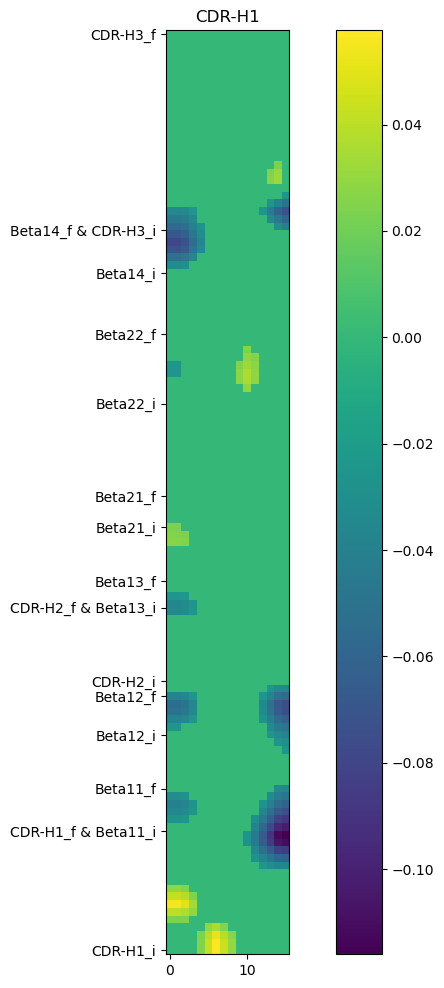

In [91]:
plt.figure(figsize=(12, 12))
cdr1_corr = cv2.resize(img, dsize=(120, 120))[:, cdr1_coord]
plt.imshow(np.where(abs(cdr1_corr)<abs(cdr1_corr).max()/5, 0, cdr1_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('CDR-H1')
plt.show()

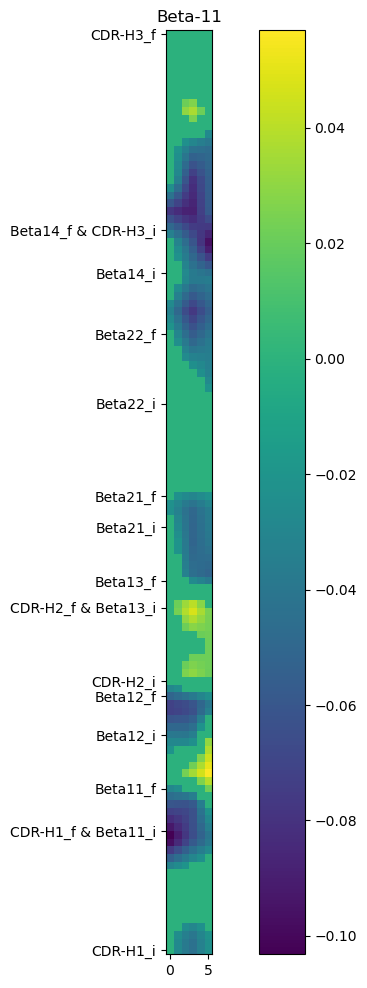

In [92]:
plt.figure(figsize=(12, 12))
beta11_corr = cv2.resize(img, dsize=(120, 120))[:, beta11_coord]
plt.imshow(np.where(abs(beta11_corr)<abs(beta11_corr).max()/5, 0, beta11_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-11')
plt.show()

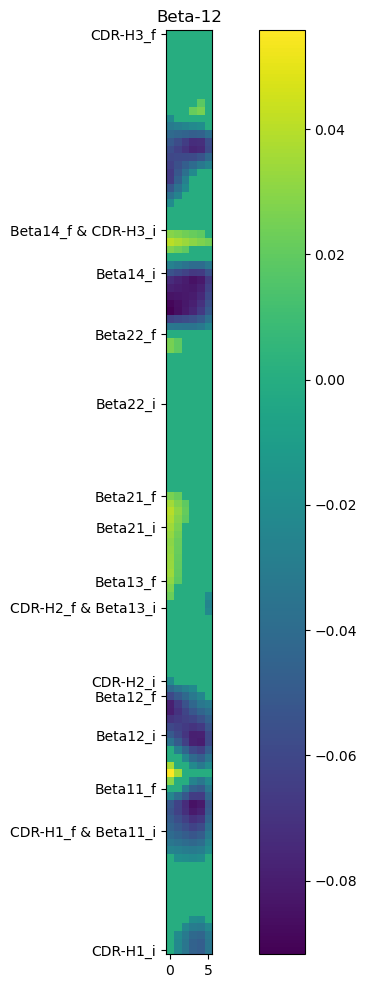

In [93]:
plt.figure(figsize=(12, 12))
beta12_corr = cv2.resize(img, dsize=(120, 120))[:, beta12_coord]
plt.imshow(np.where(abs(beta12_corr)<abs(beta12_corr).max()/5, 0, beta12_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-12')
plt.show()

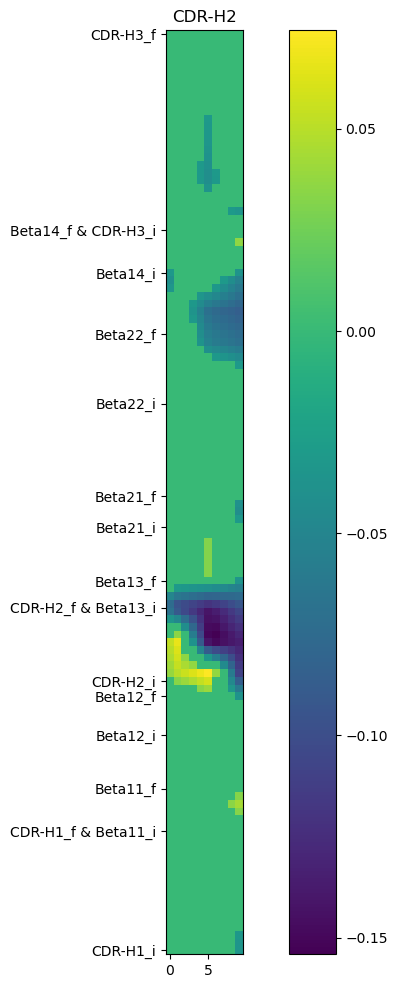

In [94]:
plt.figure(figsize=(12, 12))
cdr2_corr = cv2.resize(img, dsize=(120, 120))[:, cdr2_coord]
plt.imshow(np.where(abs(cdr2_corr)<abs(cdr2_corr).max()/5, 0, cdr2_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('CDR-H2')
plt.show()

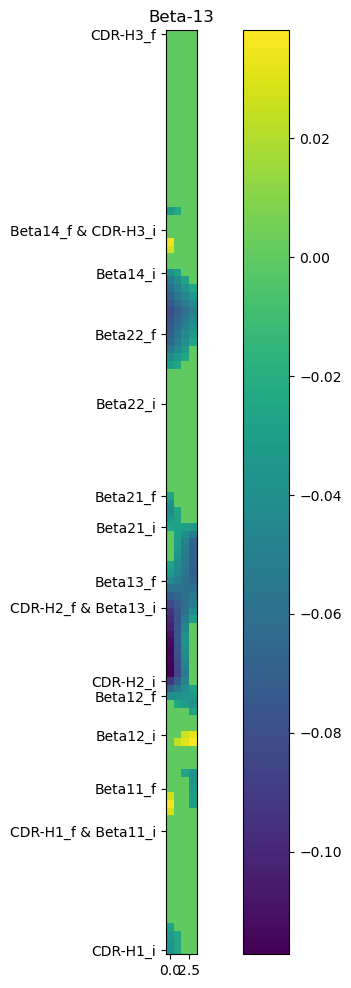

In [95]:
plt.figure(figsize=(12, 12))
beta13_corr = cv2.resize(img, dsize=(120, 120))[:, beta13_coord]
plt.imshow(np.where(abs(beta13_corr)<abs(beta13_corr).max()/5, 0, beta13_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-13')
plt.show()

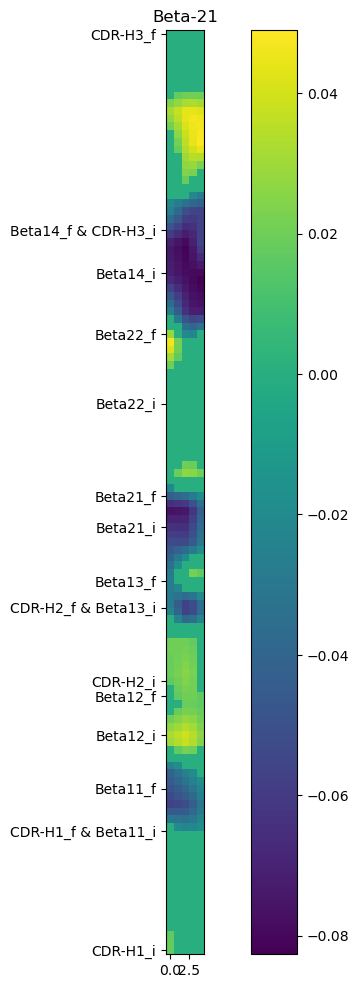

In [96]:
plt.figure(figsize=(12, 12))
beta21_corr = cv2.resize(img, dsize=(120, 120))[:, beta21_coord]
plt.imshow(np.where(abs(beta21_corr)<abs(beta21_corr).max()/5, 0, beta21_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-21')
plt.show()

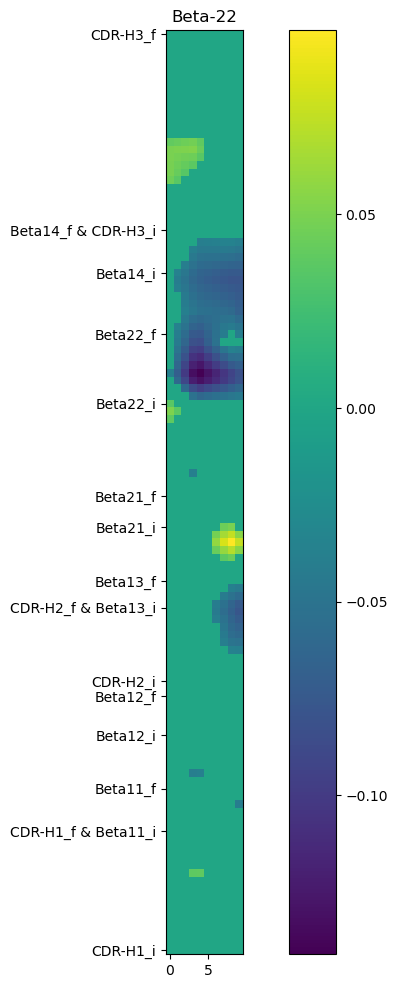

In [97]:
plt.figure(figsize=(12, 12))
beta22_corr = cv2.resize(img, dsize=(120, 120))[:, beta22_coord]
plt.imshow(np.where(abs(beta22_corr)<abs(beta22_corr).max()/4, 0, beta22_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-22')
plt.show()

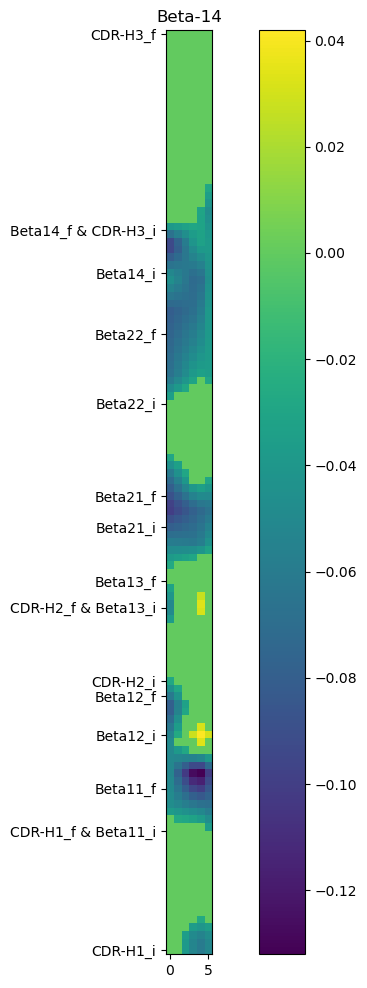

In [98]:
plt.figure(figsize=(12, 12))
beta14_corr = cv2.resize(img, dsize=(120, 120))[:, beta14_coord]
plt.imshow(np.where(abs(beta14_corr)<abs(beta14_corr).max()/5, 0, beta14_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Beta-14')
plt.show()

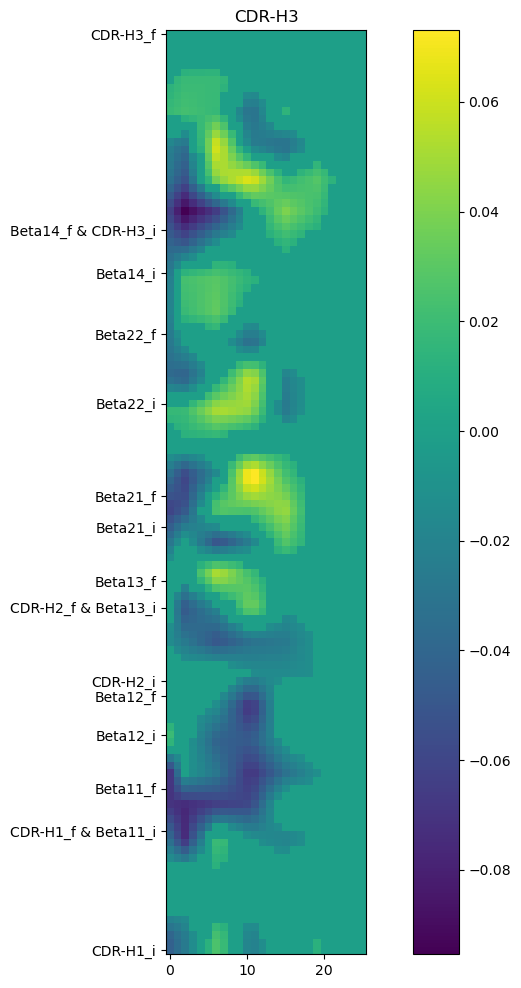

In [99]:
plt.figure(figsize=(12, 12))
cdr3_corr = cv2.resize(img, dsize=(120, 120))[:, cdr3_coord]
plt.imshow(np.where(abs(cdr3_corr)<abs(cdr3_corr).max()/8, 0, cdr3_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('CDR-H3')
plt.show()

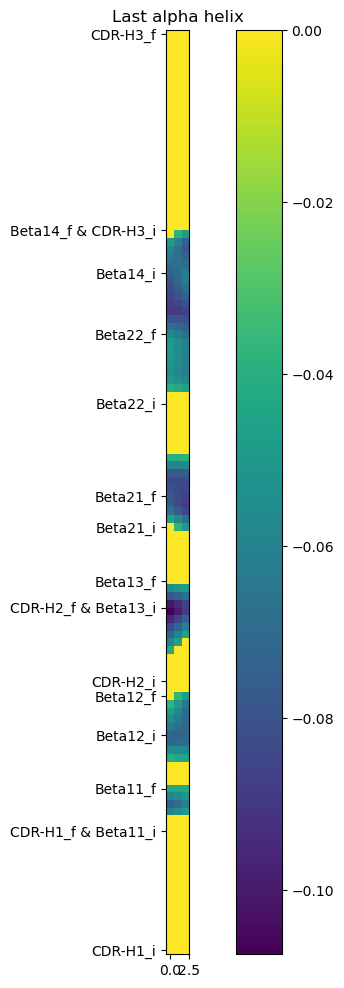

In [100]:
plt.figure(figsize=(12, 12))
alpha_corr = cv2.resize(img, dsize=(120, 120))[:, alpha_coord]
plt.imshow(np.where(abs(alpha_corr)<abs(alpha_corr).max()/3, 0, alpha_corr), origin='lower')
plt.yticks(ticks, ticks_labels, fontsize=10) 
plt.colorbar()
plt.title('Last alpha helix')
plt.show()

In [ ]:
# expanded version, total change: 13.85%
cdr3_factor = -0.05 #
cdr1_factor = 0.05 
cdr2_factor = 0.05 
beta11_factor = 0.05 
beta12_factor = -0.05 
beta13_factor = -0.05 
beta14_factor = -0.05  # 
beta21_factor = 0.05 
beta22_factor = -0.05  #
alpha_factor = 0.05

weights = np.array([cdr1_factor, beta11_factor, beta12_factor, cdr2_factor, beta13_factor, beta21_factor, beta22_factor, alpha_factor, beta14_factor, cdr3_factor])
coord = np.array([cdr1_coord, beta11_coord, beta12_coord, cdr2_coord, beta13_coord, beta21_coord, beta22_coord, alpha_coord, beta14_coord, cdr3_coord])
maps = [cdr1_corr, beta11_corr, beta12_corr, cdr2_corr, beta13_corr, beta21_corr, beta22_corr, alpha_corr, beta14_corr, cdr3_corr]

ideal = deepcopy(test_array)
for i in range(len(weights)):
    temp = np.pad(maps[i], ((0, 0), (coord[i][0], train_x.shape[2]-coord[i][-1]-1)))
    ideal += np.multiply(mask, weights[i] * (temp + np.transpose(temp)) / 2) 
plt.imshow(ideal, origin='lower')
plt.colorbar()

In [ ]:
model.eval()
new_prediction = 10**model(torch.from_numpy(ideal.reshape(1, 1, train_x.shape[2], train_x.shape[2]).astype(np.float32))).detach().numpy()
per_change = ((prediction - new_prediction) / prediction * 100)[0][0]
print(new_prediction)
print('Kd smaller by', per_change, '%')

In [ ]:
# Save Neural Network checkpoint
#EPOCH = len(val_losses)
#PATH = "model.pt"
#LOSS = tr_loss

#torch.save({
#            'epoch': EPOCH,
#            'model_state_dict': model.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'loss': LOSS,
#            }, PATH)

In [ ]:
# Load Neural Network checkpoint

#PATH = "model.pt"
#model = MultiLabelNN()
#optimizer = AdamW(model.parameters(), lr=4e-4)
#checkpoint = torch.load(PATH)
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

#model.eval()
#10**model(test_sample).detach().numpy()
# - or -
#model.train()

In [ ]:
# Save Neural Network visualization

#x_val = Variable(val_x)
#model = MultiLabelNN()
#yhat = model(x_val)
#make_dot(yhat, params=dict(list(model.named_parameters()))).render("attached", format="png")

### 